In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import GPUtil
from gklearn.utils.graphfiles import loadDataset
import networkx as nx
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import deepged.svd as svd
import deepged.rings as rings
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from deepged.triangular_losses import TriangularConstraint as triangular_constraint
import torch.autograd.profiler as profiler
from deepged.data_manager.label_manager import compute_extended_labels
from tqdm import tqdm

In [3]:
#We use a gpu 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Getting the GPU status :
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------


In [4]:
def label_to_color(label):
    if label == 'C':
        return 0.1
    elif label == 'O':
        return 0.8
    
def nodes_to_color_sequence(G):
    return [label_to_color(c[1]['label'][0]) for c in G.nodes(data=True)]

# Loading the dataset :
Gs,y = loadDataset('../data/MAO/dataset.ds')
Gs=Gs[:20]
y=y[:20]

print("Length of Gs = ",len(Gs))
#print('edge max label',max(max([[G[e[0]][e[1]]['bond_type'] for e in G.edges()] for G in Gs])))

for g in Gs:
    compute_extended_labels(g,label_node='label')


Length of Gs =  20


In [5]:
'''
G1 = Gs[1]
G2 = Gs[9]

plt.figure(0)
nx.draw_networkx(G1,with_labels=True,node_color = nodes_to_color_sequence(G1),cmap='autumn')

plt.figure(1)
nx.draw_networkx(G2,with_labels=True,node_color = nodes_to_color_sequence(G2),cmap='autumn')

plt.show()
'''

"\nG1 = Gs[1]\nG2 = Gs[9]\n\nplt.figure(0)\nnx.draw_networkx(G1,with_labels=True,node_color = nodes_to_color_sequence(G1),cmap='autumn')\n\nplt.figure(1)\nnx.draw_networkx(G2,with_labels=True,node_color = nodes_to_color_sequence(G2),cmap='autumn')\n\nplt.show()\n"

In [6]:
# The class Net representing the neural network :

class Net(nn.Module):
        
    def __init__(self,GraphList,normalize=False,node_label='label'):
        super(Net, self).__init__()   
        self.normalize=normalize
        self.node_label=node_label
        dict,self.nb_edge_labels=self.build_node_dictionnary(GraphList)
        self.nb_labels=len(dict)
        print("nb_edge_labels = ",self.nb_edge_labels)
        self.device= torch.device("cpu")  #'cuda' if torch.cuda.is_available() else 'cpu'
        nb_node_pair_label=self.nb_labels*(self.nb_labels-1)/2.0
        nb_edge_pair_label=int(self.nb_edge_labels*(self.nb_edge_labels-1)/2)
        
        self.node_weighs=nn.Parameter(torch.tensor(1.0/(nb_node_pair_label+nb_edge_pair_label+2))+(1e-3)*torch.rand(int(self.nb_labels*(self.nb_labels-1)/2+1),requires_grad=True,device=self.device)) # all substitution costs+ nodeIns/Del. old version: 0 node subs, 1 nodeIns/Del, 2 : edgeSubs, 3 edgeIns/Del        
        self.edge_weighs=nn.Parameter(torch.tensor(1.0/(nb_node_pair_label+nb_edge_pair_label+2))+(1e-3)*torch.rand(nb_edge_pair_label+1,requires_grad=True,device=self.device)) #edgeIns/Del
        self.card=torch.tensor([G.order() for G in GraphList]).to(self.device)
        card_max=self.card.max()
        self.A=torch.zeros((len(GraphList),card_max*card_max),dtype=torch.int,device=self.device) 
        self.labels=torch.zeros((len(GraphList),card_max),dtype=torch.int,device=self.device) #node labels 
        for k in range(len(GraphList)):
            A,l=self.from_networkx_to_tensor(GraphList[k],dict)             
            self.A[k,0:A.shape[1]]=A[0]
            self.labels[k,0:l.shape[0]]=l
        print('adjacency matrices',self.A)
        print('node labels',self.labels)
        print('order of the graphs',self.card)
        
    # The forward pass of the neural network 
    def forward(self, input):  
        self=self.to(self.device)
        input=input.to(self.device)
        ged=torch.zeros(len(input)).to(self.device) 
        node_costs,nodeInsDel,edge_costs,edgeInsDel=self.from_weighs_to_costs()
        
        # Here, we empty the cache so that the gpu doesn't keep all the information all along
        torch.cuda.empty_cache()
        GPUtil.showUtilization(all=True)
        
        for k in tqdm(range(len(input))): 
            g1=input[k][0].to(self.device)
            g2=input[k][1].to(self.device)
            n=self.card[g1]
            m=self.card[g2]
            
            # Building the rings around every couple of graphs 
            self.ring_g,self.ring_h = rings.build_rings(g1,edgeInsDel.size()), rings.build_rings(g2,edgeInsDel.size()) 
            
            # Constructing a cost matrix C for every couple of graphs, given the different costs 
            C=self.construct_cost_matrix(g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel) 
            
            # Calculating an optimal mapping S based on the cost matrix C 
            S=self.mapping_from_cost_sans_FW(n,m,g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel)
            #S=self.mapping_from_cost(C,n,m)   
            #S=self.new_mapping_from_cost(C,n,m,g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel)
            
            # Flattenning S by reshaping it into a one-dimensional tensor
            v=torch.flatten(S).to(self.device)
            
            # Detaching from the current graph, so that the result will never require gradient
            S=S.detach()
            normalize_factor=1.0
            if self.normalize:
                nb_edge1=(self.A[g1][0:n*n] != torch.zeros(n*n,device=self.device)).int().sum()
                nb_edge2=(self.A[g2][0:m*m] != torch.zeros(m*m,device=self.device)).int().sum()
                normalize_factor=nodeInsDel*(n+m)+edgeInsDel*(nb_edge1+nb_edge2)
            
            # Getting the main diagonal of the cost matrix C
            c=torch.diag(C)
            D=C-torch.eye(C.shape[0],device=self.device)*c
            
            # Calculating the optimal ged for every couple of graphs, based on c, v and D 
            ged[k]=(.5*v.T@D@v+c.T@v)/normalize_factor
            
            # We delete C after every iteration so that it's not kept in memory, because torch keeps it automatically
            del C
            torch.cuda.empty_cache()

        max=torch.max(ged)
        min=torch.min(ged)
        ged=(ged-min)/(max-min)
        
        return ged
    
    def from_weighs_to_costs(self):
        # We apply the ReLU (rectified linear unit) function element-wise
        relu=torch.nn.ReLU()
        cn=relu(self.node_weighs)
        ce=relu(self.edge_weighs)
        edgeInsDel=ce[-1]
        
        # Or we can use the exponential function
        # Returns a new tensor with the exponential of the elements of the input tensor 
        '''
        #cn=torch.exp(self.node_weighs)
        #ce=torch.exp(self.edge_weighs)
        cn=self.node_weighs*self.node_weighs
        ce=self.edge_weighs*self.edge_weighs
        total_cost=cn.sum()+ce.sum()
        cn=cn/total_cost #/max
        ce=ce/total_cost
        edgeInsDel=ce[-1]
        '''
        
        # Initialization of the node costs
        node_costs=torch.zeros((self.nb_labels,self.nb_labels),device=self.device)
        upper_part=torch.triu_indices(node_costs.shape[0],node_costs.shape[1],offset=1,device=self.device)        
        node_costs[upper_part[0],upper_part[1]]=cn[0:-1]
        node_costs=node_costs+node_costs.T

        if self.nb_edge_labels>1:
            edge_costs=torch.zeros((self.nb_edge_labels,self.nb_edge_labels),device=self.device)
            upper_part=torch.triu_indices(edge_costs.shape[0],edge_costs.shape[1],offset=1,device=self.device)        
            edge_costs[upper_part[0],upper_part[1]]=ce[0:-1]
            edge_costs=edge_costs+edge_costs.T
            del upper_part
            torch.cuda.empty_cache()
        else:
            edge_costs=torch.zeros(0,device=self.device)
        
        return node_costs,cn[-1],edge_costs,edgeInsDel
    
    # Extraction of all atom labels 
    def build_node_dictionnary(self,GraphList):
        node_labels=[]
        for G in Gs:
            for v in nx.nodes(G):
                if not G.nodes[v][self.node_label][0] in node_labels:
                    node_labels.append(G.nodes[v][self.node_label][0])
        node_labels.sort()
        # Extraction of a dictionary allowing to number each label by a number.
        dict={}
        k=0
        for label in node_labels:
            dict[label]=k
            k=k+1
        print("node_labels : ",node_labels)
    
        return dict,max(max([[int(G[e[0]][e[1]]['bond_type']) for e in G.edges()] for G in GraphList]))
    
    # Transforming a networkx to a torch tensor
    def from_networkx_to_tensor(self,G,dict):    
        A=torch.tensor(nx.to_scipy_sparse_matrix(G,dtype=int,weight='bond_type').todense(),dtype=torch.int)        
        lab=[dict[G.nodes[v][self.node_label][0]] for v in nx.nodes(G)]
   
        return (A.view(1,A.shape[0]*A.shape[1]),torch.tensor(lab))

    # This function is used to construct a cost matrix C between two graphs g1 and g2, given the costs
    def construct_cost_matrix(self,g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel):
        n = self.card[g1].item()
        m = self.card[g2].item()
        
        # We use the no_grad to disable gradient calculation, that will reduce memory consumption 
        with torch.no_grad() : 
            A1=torch.zeros((n+1,n+1),dtype=torch.int,device=self.device)
            A1[0:n,0:n]=self.A[g1][0:n*n].view(n,n)
            A2=torch.zeros((m+1,m+1),dtype=torch.int,device=self.device)
            A2[0:m,0:m]=self.A[g2][0:m*m].view(m,m)

         # costs: 0 node subs, 1 nodeIns/Del, 2 : edgeSubs, 3 edgeIns/Del
        
        #C=cost[3]*torch.cat([torch.cat([C12[l][k] for k in range(n+1)],1) for l in range(n+1)])
        C=edgeInsDel*self.matrix_edgeInsDel(A1,A2)
        if self.nb_edge_labels>1:
            for k in range(self.nb_edge_labels):
                for l in range(self.nb_edge_labels):
                    if k != l:
                        C.add_(self.matrix_edgeSubst(A1,A2,k+1,l+1).multiply_(edge_costs[k][l]))
                        C=C+edge_costs[k][l]*self.matrix_edgeSubst(A1,A2,k+1,l+1) 
        
        l1=self.labels[g1][0:n]
        l2=self.labels[g2][0:m]
        D=torch.zeros((n+1)*(m+1),device=self.device)
        D[n*(m+1):]=nodeInsDel
        D[n*(m+1)+m]=0
        D[[i*(m+1)+m for i in range(n)]]=nodeInsDel
        for k in range(n*(m+1)):
            if k%(m+1) != m:
                D[k]=node_costs[l1[k//(m+1)]][l2[k%(m+1)]]
        mask = torch.diag(torch.ones_like(D))
        C=mask*torch.diag(D) #+ (1. - mask)*C

        return C
    
    def matrix_edgeInsDel(self,A1,A2):
        Abin1=(A1!=torch.zeros((A1.shape[0],A1.shape[1]),device=self.device))
        Abin2=(A2!=torch.zeros((A2.shape[0],A2.shape[1]),device=self.device))
        C1=torch.einsum('ij,kl->ijkl',torch.logical_not(Abin1),Abin2)
        C2=torch.einsum('ij,kl->ijkl',Abin1,torch.logical_not(Abin2))
        C12=torch.logical_or(C1,C2).int()
        return torch.cat(torch.unbind(torch.cat(torch.unbind(C12,1),1),0),1)

    def matrix_edgeSubst(self,A1,A2,lab1,lab2):
        Abin1=(A1==lab1*torch.ones((A1.shape[0],A1.shape[1]),device=self.device)).int()
        Abin2=(A2==lab2*torch.ones((A2.shape[0],A2.shape[1]),device=self.device)).int()
        C=torch.einsum('ij,kl->ijkl',Abin1,Abin2)
        return torch.cat(torch.unbind(torch.cat(torch.unbind(C,1),1),0),1).float()
    
    # ring_g, ring_h come from global ring with all graphs in so ring_g = rings['g'] and ring_h = rings['h']
    def lsape_populate_instance(self,first_graph,second_graph,average_node_cost, average_edge_cost,alpha,lbda):
        g,h = Gs[first_graph], Gs[second_graph]
        self.average_cost =[average_node_cost, average_edge_cost]
        self.first_graph, self.second_graph = first_graph,second_graph
        
        node_costs,nodeInsDel,edge_costs,edgeInsDel=self.from_weighs_to_costs()

        lsape_instance = [[0 for _ in range(len(g) + 1)] for __ in range(len(h) + 1)]
        for g_node_index in range(len(g) + 1):
            for h_node_index in range(len(h) + 1):
                lsape_instance[h_node_index][g_node_index] = rings.compute_ring_distance(g,h,self.ring_g,self.ring_h,g_node_index,h_node_index,alpha,lbda,node_costs,nodeInsDel,edge_costs,edgeInsDel,first_graph,second_graph)
        for i in lsape_instance :
            i = torch.as_tensor(i)
        lsape_instance = torch.as_tensor(lsape_instance)
        return lsape_instance
    
    # Calculating a mapping based on the cost matrix C, using the rings function and a derivable Hungarian approximation
    def mapping_from_cost_sans_FW(self,n,m,g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel): 
        c_0 =self.lsape_populate_instance(g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel)
        x0=svd.eps_assigment_from_mapping(torch.exp(-c_0),10).view((n+1)*(m+1),1)
        return x0
    
    # Calculating a mapping based on the cost matrix C, not using the rings function and using a derivable Hungarian approximation
    def new_mapping_from_cost(self,C,n,m,g1,g2,node_costs,edge_costs,nodeInsDel,edgeInsDel): 
        c=torch.diag(C)       
        D=C-torch.eye(C.shape[0],device=self.device)*c
        x0=svd.eps_assigment_from_mapping(torch.exp(-c),10).view((n+1)*(m+1),1)
        return x0
    
    # Calculating a mapping based on the cost matrix C, not using the rings function and using the Frank Wolfe algorithm
    def mapping_from_cost(self,C,n,m):
        c=torch.diag(C)
        D=C-torch.eye(C.shape[0],device=self.device)*c
        x0=svd.eps_assigment_from_mapping(torch.exp(-.5*c.view(n+1,m+1)),10).view((n+1)*(m+1),1)
        x=svd.franck_wolfe(x0,D,c,5,10,n,m)
        def print_grad(grad):
            if(grad.norm()!= 0.0):
                print(grad)        
        return x



In [7]:
# Creating our model, and sending it to the gpu

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = Net(Gs,normalize=True,node_label='extended_label')
model.to(device)


node_labels :  ['C_1C', 'C_1C1C1N', 'C_1C1C2C', 'C_1C1N', 'C_1C1N2C', 'C_1C2C', 'C_1C3C', 'C_1N', 'C_2C', 'C_2C2C', 'C_3C', 'N_1C', 'N_1C1C', 'N_1C1C1C']
nb_edge_labels =  3
adjacency matrices tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], dtype=torch.int32)
node labels tensor([[12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 11,  0,  0,  0,  0,  0,  0,  0,
          0],
        [12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 12,  7,  0,  0,  0,  0,  0,  0,
          0],
        [12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 12,  1,  0,  0,  0,  0,  0,  0,
          0],
        [12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 12,  3,  6, 10,  0,  0,  0,  0,
          0],
        [12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 13,  3,  6, 10,  7,  0,  0,  0,
          0],
        [12,  4,  5,  2,  5,  5,  5,  5,  4,  3, 13,  3,  6, 10,  1,  0,  0,  0,
  

Net()

In [8]:
# This function creates sets of couples of graphs from sets of graphs 

def creating_couples_after_splitting(train_D, valid_D,train_L,valid_L):
    couples_train=[]
    couples_test_train=[]
    for i,g1_idx in enumerate(train_D): 
        for j,g2_idx in enumerate(train_D):
            n=g1_idx
            m=g2_idx
            couples_train.append([n,m])
    yt=np.ones(len(couples_train))
    for k in couples_train:
        if (y[k[0]]!=y[k[1]]):
            yt[k]=-1.0  
    for i,g1_idx in enumerate(valid_D):
        for j,g2_idx in enumerate(train_D):
            n=g1_idx
            m=g2_idx
            couples_test_train.append([n,m])
            
    yv=np.ones(len(couples_test_train))
    for k in couples_test_train:
        if (y[k[0]]!=y[k[1]]):
            yv[k]=-1.0
            
    return torch.tensor(couples_train),yt,torch.tensor(couples_test_train),yv

In [9]:
# Verifying that the two sets contain different graphs

def different_sets(my_train_D,my_valid_D): 
    cp=my_valid_D
    for i in range(len(my_valid_D)):
        if my_valid_D[i] in my_train_D:
            tmp=random.choice(Gs)
            if tmp not in my_train_D: 
                cp[i]=tmp
    my_valid_D=cp
    
    return my_train_D,my_valid_D

In [10]:
# This function splits the graph list Gs into two distinct sets of couples of graphs
# One for training the model and one for testing it

def splitting(Gs): 
    my_list=[i for i in range(len(Gs))] 

    [train_D, valid_D,train_L,valid_L]= train_test_split(my_list,y, test_size=0.20,train_size=0.80, shuffle=True, stratify=y) # we stratify so that y is used as the class labels
    # We make sure that the two sets contain distinct graphs
    train_D, valid_D=different_sets(train_D,valid_D)
    
    couples_train,yt,couples_test_train,yv = creating_couples_after_splitting(train_D, valid_D,train_L,valid_L)
    yt=torch.tensor(yt)
    yv=torch.tensor(yv)
    DatasetTrain = TensorDataset(couples_train,yt) 
    DatasetValid=TensorDataset(couples_test_train, yv)

    trainloader=torch.utils.data.DataLoader(DatasetTrain,batch_size=len(couples_train),shuffle=True,drop_last=True, num_workers=0) #128, len(couples_train)
    validationloader=torch.utils.data.DataLoader(DatasetValid, batch_size=len(couples_test_train), drop_last=True,num_workers=0) #64,128,len(couples_test_train)
    
    print(len(trainloader),len(validationloader))
    print(len(trainloader),len(validationloader))
    
    # We save our sets in pickle files
    #torch.save(train_D, 'pickle_files/train_D', pickle_module=pkl) 
    #torch.save(valid_D, 'pickle_files/valid_D', pickle_module=pkl) 
    #torch.save(train_L, 'pickle_files/train_L', pickle_module=pkl) 
    #torch.save(valid_L, 'pickle_files/valid_L', pickle_module=pkl) 
    
    return trainloader,validationloader,couples_train,yt,couples_test_train,yv

In [11]:
# This is the function used for classification problems

def classification(model,Gs,nb_iter):
    
    trainloader,validationloader,couples_train,yt,couples_test_train,yv=splitting(Gs)
    criterion = torch.nn.HingeEmbeddingLoss(margin=1.0,reduction='mean')
    criterionTri=triangular_constraint()
    optimizer = torch.optim.Adam(model.parameters()) #, lr=1e-3
    
    train_input=couples_train.to(device)
    #valid_input=couples_test_train.to(device)
    
    target=yt.to(device) 
    InsDel=np.empty((nb_iter,2))
    node_costs,nodeInsDel,edge_costs,edgeInsDel=model.from_weighs_to_costs()
    nodeSub=np.empty((nb_iter,int(node_costs.shape[0]*(node_costs.shape[0]-1)/2)))
    edgeSub=np.empty((nb_iter,int(edge_costs.shape[0]*(edge_costs.shape[0]-1)/2)))
    loss_plt=np.empty(nb_iter)
    loss_train_plt=np.empty(nb_iter)
    loss_valid_plt=np.empty(nb_iter)
    min_valid_loss = np.inf
    iter_min_valid_loss = 0
    
    
    for t in range(nb_iter):   
        print(f"epoch {t}")
        train_loss = 0.0
        valid_loss = 0.0
        tmp=np.inf
        
        # The training part :
        for train_data,train_labels in trainloader:
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            #inputt=train_data.to(device)
            
            # Forward pass: Compute predicted y by passing data to the model
            y_pred = model(train_data).to(device)  

            # Computing and printing loss
            train_labels=train_labels.to(device)
            loss = criterion(y_pred, train_labels).to(device)
            node_costs,nodeInsDel,edge_costs,edgeInsDel=model.from_weighs_to_costs()
            triangularInq=criterionTri(node_costs,nodeInsDel,edge_costs,edgeInsDel)
            loss=loss*(1+triangularInq)
            loss.to(device)
            loss.backward()
            loss=loss.detach()
            
            optimizer.step()
            
            print('grad loss of the train = ', t, loss.grad)
            print('loss.item of the train = ', t, loss.item())
            train_loss =+ loss.item() #* train_data.size(0) 
            if (loss.item()<tmp): tmp=loss.item()
                
         # Getting the training loss
        loss_plt[t]=loss.item()  
        loss_train_plt[t]=train_loss /len(trainloader)
        #loss_plt[t]=tmp
          
        # Getting the costs of the first iteration, to compare later
        if t==0:
            nodeInsDelInit=nodeInsDel
            edgeInsDelInit=edgeInsDel
            nodeSubInit=node_costs
            edgeSubInit=edge_costs
            torch.save(nodeInsDelInit, 'pickle_files/nodeInsDelInit', pickle_module=pkl) 
            torch.save(edgeInsDelInit, 'pickle_files/edgeInsDelInit', pickle_module=pkl) 
            torch.save(nodeSubInit, 'pickle_files/nodeSubInit', pickle_module=pkl) 
            torch.save(edgeSubInit, 'pickle_files/edgeSubInit', pickle_module=pkl) 

        # Getting some information every 100 iterations, to follow the evolution
        if t % 100 == 99 or t==0:   
            print('ged=',y_pred*target)  #train_labels
            print('Distances: ',y_pred)
            print('Loss Triangular:',triangularInq.item())
            print('node_costs : \n', node_costs)
            print('nodeInsDel:',nodeInsDel.item())
            print('edge_costs : \n', edge_costs)
            print('edgeInsDel:',edgeInsDel.item())
        
        print(f'Iteration {t+1} \t\t Training Loss: {train_loss / len(trainloader)}')
        
        # We delete to liberate some memory
        del y_pred, train_loss,loss
        torch.cuda.empty_cache()
        
        # The validation part :
        for valid_data,valid_labels in validationloader:
            inputt=valid_data.to(device)
            y_pred = model(inputt).to(device)
            # Compute and print loss
            valid_labels=valid_labels.to(device)
            loss = criterion(y_pred, valid_labels).to(device)    
            loss.to(device)
            print('loss.item of the valid = ', t, loss.item())  
            
            valid_loss = valid_loss + loss.item() #* valid_data.size(0)

        # Getting the validation loss
        loss_valid_plt[t]=valid_loss / len(validationloader)   
        
        # Getting edges and nodes Insertion/Deletion costs
        InsDel[t][0]=nodeInsDel.item()
        InsDel[t][1]=edgeInsDel.item()
        
        k=0
        for p in range(node_costs.shape[0]):
            for q in range(p+1,node_costs.shape[0]):
                nodeSub[t][k]=node_costs[p][q]
                k=k+1
        k=0
        for p in range(edge_costs.shape[0]):
            for q in range(p+1,edge_costs.shape[0]):
                edgeSub[t][k]=edge_costs[p][q]
                k=k+1
        
        print(f'Iteration {t+1} \t\t Validation Loss: {valid_loss/len(validationloader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
            min_valid_loss = valid_loss
            iter_min_valid_loss = t
            nodeSub_min = node_costs
            edgeSub_min = edge_costs
            nodeInsDel_min = nodeInsDel
            edgeInsDel_min = edgeInsDel
        
        # We delete to liberate some memory
        del valid_loss,loss
        torch.cuda.empty_cache()                
            
    print('iter and min_valid_loss = ',iter_min_valid_loss, min_valid_loss)
    print(' Min cost for nodeInsDel = ', nodeInsDel_min)
    print(' Min cost for edgeInsDel = ', edgeInsDel_min)
    print(' Min cost for nodeSub = ', nodeSub_min)
    print(' Min cost for edgeSub = ', edgeSub_min)
    # Saving the minimum costs into pickle files
    torch.save(nodeInsDel_min, 'pickle_files/nodeInsDel_min', pickle_module=pkl) 
    torch.save(edgeInsDel_min, 'pickle_files/edgeInsDel_min', pickle_module=pkl) 
    torch.save(nodeSub_min, 'pickle_files/nodeSub_min', pickle_module=pkl) 
    torch.save(edgeSub_min, 'pickle_files/edgeSub_min', pickle_module=pkl)
    return InsDel,nodeSub,edgeSub,loss_plt,loss_valid_plt,loss_train_plt



In [12]:
print(len(Gs))
nb_iter=5

InsDel, nodeSub,edgeSub,loss_plt,loss_valid_plt,loss_train_plt=classification(model,Gs,nb_iter)

# Plotting Node/Edge insertion/deletion costs
plt.figure(0)
plt.plot(InsDel[0:nb_iter,0],label="node")
plt.plot(InsDel[0:nb_iter,1],label="edge")
plt.title('Node/Edge insertion/deletion costs')
plt.legend()

# Plotting Node Substitutions costs
plt.figure(1)
for k in range(nodeSub.shape[1]):
    plt.plot(nodeSub[0:nb_iter,k])
plt.title('Node Substitutions costs')

# Plotting Edge Substitutions costs
plt.figure(2)
for k in range(edgeSub.shape[1]):
    plt.plot(edgeSub[0:nb_iter,k])
plt.title('Edge Substitutions costs')

# Plotting the evolution of the train loss
plt.figure(3)
plt.plot(loss_plt)
plt.title('Evolution of the train loss (loss_plt)')

# Plotting the evolution of the validation loss
plt.figure(4)
plt.plot(loss_valid_plt)
plt.title('Evolution of the valid loss')

plt.show()
plt.close()

20
1 1
1 1
epoch 0
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:59<00:00,  4.33it/s]


grad loss of the train =  0 None
loss.item of the train =  0 0.44381392002105713
ged= tensor([-0.4872, -0.6927, -0.3384,  0.4745, -0.3613, -0.1665, -0.4775, -0.2812,
        -0.3666,  0.6997, -0.2924, -0.3110, -0.3401, -0.0575, -0.6307, -0.5376,
        -0.9035, -0.3135,  0.4059,  0.3594,  0.4430,  0.4537,  0.4705,  0.4705,
         0.5663,  0.5023,  0.3017,  0.3601,  0.6857,  0.7168,  0.6695,  0.4801,
         0.3783,  0.4042,  0.5040,  0.4507,  0.0313,  0.3891,  0.8030,  0.4924,
         0.0410,  0.2523,  0.3486,  0.3758,  0.4004,  0.4686,  0.4775,  0.3499,
         0.1384,  0.3785,  0.4323,  0.4796,  0.3693,  0.6055,  0.4049,  0.3939,
         0.3183,  0.3331,  0.3586,  0.0414,  0.2877,  0.2362,  0.5071,  0.4480,
         0.4888,  0.3811,  0.3960,  0.2760,  0.4450,  0.3088,  0.5639,  0.3778,
         0.2029,  0.8171,  0.1687,  0.3674,  0.4846,  0.4694,  0.3594,  0.4044,
         0.4766,  0.5204,  0.5845,  0.3057,  0.4429,  0.4934,  0.4686,  0.1821,
         0.4883,  0.4113,  0.8021,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:15<00:00,  4.08it/s]


loss.item of the valid =  0 0.5016830563545227
Iteration 1 		 Validation Loss: 0.5016830563545227
Validation Loss Decreased(inf--->0.501683)
epoch 1
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:59<00:00,  4.27it/s]


grad loss of the train =  1 None
loss.item of the train =  1 0.39528271555900574
Iteration 2 		 Training Loss: 0.39528271555900574
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:16<00:00,  3.92it/s]


loss.item of the valid =  1 0.523048460483551
Iteration 2 		 Validation Loss: 0.523048460483551
epoch 2
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:00<00:00,  4.24it/s]


grad loss of the train =  2 None
loss.item of the train =  2 0.33250582218170166
Iteration 3 		 Training Loss: 0.33250582218170166
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:15<00:00,  4.03it/s]


loss.item of the valid =  2 0.5264009237289429
Iteration 3 		 Validation Loss: 0.5264009237289429
epoch 3
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:01<00:00,  4.19it/s]


grad loss of the train =  3 None
loss.item of the train =  3 0.31230542063713074
Iteration 4 		 Training Loss: 0.31230542063713074
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.31it/s]


loss.item of the valid =  3 0.5194927453994751
Iteration 4 		 Validation Loss: 0.5194927453994751
epoch 4
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:01<00:00,  4.15it/s]


grad loss of the train =  4 None
loss.item of the train =  4 0.2855408489704132
Iteration 5 		 Training Loss: 0.2855408489704132
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.37it/s]


loss.item of the valid =  4 0.5142555236816406
Iteration 5 		 Validation Loss: 0.5142555236816406
iter and min_valid_loss =  0 0.5016830563545227
 Min cost for nodeInsDel =  tensor(0.0112, grad_fn=<SelectBackward0>)
 Min cost for edgeInsDel =  tensor(0.0106, grad_fn=<SelectBackward0>)
 Min cost for nodeSub =  tensor([[0.0000, 0.0110, 0.0114, 0.0113, 0.0107, 0.0110, 0.0106, 0.0111, 0.0106,
         0.0107, 0.0114, 0.0108, 0.0108, 0.0113],
        [0.0110, 0.0000, 0.0109, 0.0113, 0.0113, 0.0105, 0.0111, 0.0106, 0.0110,
         0.0113, 0.0106, 0.0110, 0.0111, 0.0113],
        [0.0114, 0.0109, 0.0000, 0.0111, 0.0108, 0.0114, 0.0107, 0.0111, 0.0111,
         0.0109, 0.0109, 0.0111, 0.0112, 0.0113],
        [0.0113, 0.0113, 0.0111, 0.0000, 0.0109, 0.0112, 0.0105, 0.0111, 0.0109,
         0.0109, 0.0105, 0.0105, 0.0106, 0.0112],
        [0.0107, 0.0113, 0.0108, 0.0109, 0.0000, 0.0112, 0.0110, 0.0112, 0.0108,
         0.0109, 0.0111, 0.0106, 0.0110, 0.0111],
        [0.0110, 0.0105, 0.0114, 0

/tmp/ipykernel_39618/1074445101.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [13]:
# We save the losses into pickle files
torch.save(loss_plt, 'pickle_files/loss_plt', pickle_module=pkl) 
torch.save(loss_valid_plt, 'pickle_files/loss_valid_plt', pickle_module=pkl) 
torch.save(loss_train_plt, 'pickle_files/loss_train_plt', pickle_module=pkl) 

# We save the costs into pickle files
torch.save(InsDel,'pickle_files/InsDel', pickle_module=pkl) 
torch.save(edgeSub,'pickle_files/edgeSub', pickle_module=pkl) 
torch.save(nodeSub,'pickle_files/nodeSub', pickle_module=pkl) 


In [14]:
A=torch.tensor(nx.to_scipy_sparse_matrix(Gs[0],dtype=int,weight='bond_type').todense(),dtype=torch.int) 
print(A)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0],
        [1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.int32)


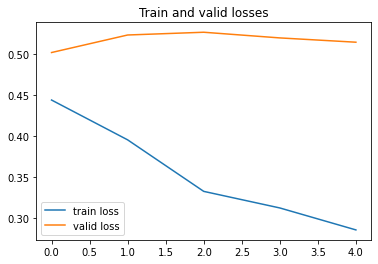

In [15]:
# Plotting the train and the valid losses in a same graphic, to compare their evolution
import matplotlib.pyplot as plt 
%matplotlib inline
plt.plot(loss_plt, label='train loss')
plt.plot(loss_valid_plt, label='valid loss')
plt.title('Train and valid losses')
plt.legend()
plt.show()
plt.close()

In [16]:
card = torch.tensor([G.order() for G in Gs]).to(device)
print(Gs[0].order())

11
